# 2021/05/27

$\newcommand{\ket}[1]{| #1 \rangle}$

## 量子機械学習

変分量子回路を用いた量子機械学習アルゴリズムは、一般的には以下のような順番で量子回路に実装され、計算が行われます。

1. **学習データ**$\{(\mathbf{x}_i, y_i)\}$を用意する。$\mathbf{x}_i$は入力データのベクトル、$y_i$は入力データに対する真の値（教師データ）とする（$i$は学習データのサンプルを表す添字）。
2. 入力$\mathbf{x}$から何らかの規則で決まる回路$U_{\text{in}}(\mathbf{x})$（**特徴量マップ**と呼ぶ）を用意し、$\mathbf{x}_i$の情報を埋め込んだ入力状態$\ket{\psi_{\text{in}}(\mathbf{x}_i)} = U_{\text{in}}(\mathbf{x}_i)\ket{0}$を作る。
3. 入力状態にパラメータ$\boldsymbol{\theta}$に依存したゲート$U(\boldsymbol{\theta})$（**変分フォーム**）を掛けたものを出力状態$\ket{\psi_{\text{out}}(\mathbf{x}_i,\boldsymbol{\theta})} = U(\boldsymbol{\theta})\ket{\psi_{\text{in}}(\mathbf{x}_i)}$とする。
4. 出力状態のもとで何らかの**観測量**を測定し、測定値$O$を得る。例えば、最初の量子ビットで測定したパウリ$Z$演算子の期待値$\langle Z_1\rangle = \langle \psi_{\text{out}}|Z_1|\psi_{\text{out}} \rangle$などを考える。
5. $F$を適当な関数として、$F(O)$をモデルの出力$y(\mathbf{x}_i,\boldsymbol{\theta})$とする。
6. 真の値$y_i$と出力$y(\mathbf{x}_i,\boldsymbol{\theta})$の間の乖離を表す**コスト関数**$L(\boldsymbol{\theta})$を定義し、古典計算でコスト関数を計算する。
7. $L(\boldsymbol{\theta})$が小さくなるように$\boldsymbol{\theta}$を更新する。
7. 3-7のプロセスを繰り返すことで、コスト関数を最小化する$\boldsymbol{\theta}=\boldsymbol{\theta^*}$を求める。
8. $y(\mathbf{x},\boldsymbol{\theta^*})$が学習によって得られた**予測モデル**になる。

<img src='figs/var_circuit.png' width="600" height="400">

この順に量子機械学習アルゴリズムを実装していきましょう。まず、必要なライブラリを最初にインポートします。

In [1]:
# Tested with python 3.7.9, qiskit 0.23.5, numpy 1.20.1
import logging
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.circuit.library import TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.aqua import QuantumInstance, set_qiskit_aqua_logging
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.algorithms.optimizers import SPSA, COBYLA

#set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

/Users/terashi/miniconda3/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


## 初歩的な例<a id='example'></a>

ある入力$\{x_i\}$と、既知の関数$f$による出力$y_i=f(x_i)$が学習データとして与えられた時に、そのデータから関数$f$を近似的に求める問題を考えてみます。例として、$f(x)=x^3$としてみます。

### 学習データの準備<a id='func_data'></a>

まず、学習データを準備します。$x_{\text{min}}$と$x_{\text{max}}$の範囲でデータを`num_x_train`個ランダムに取った後、正規分布に従うノイズを追加しておきます。`nqubit`が量子ビット数、`c_depth`が変分フォーム回路の深さを表します。

In [2]:
random_seed = 0
np.random.seed(random_seed)

# Qubit数、回路の深さ、訓練サンプル数の定義など
nqubit = 3
c_depth = 5
x_min = -1.; x_max = 1.; num_x_train = 30

# パラメータ数の設定
num_vars = nqubit*3*(c_depth+1)
params = np.random.rand(num_vars)*2*np.pi

# 関数の定義
func_to_learn = lambda x: x**3
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# 関数に正規分布ノイズを付加
mag_noise = 0.05
y_train_noise = y_train + mag_noise * np.random.randn(num_x_train)

# 学習データを表示
x_list = np.arange(x_min, x_max, 0.02)
plt.plot(x_train, y_train_noise, "o", label='Training Data (w/ Noise)')
plt.plot(x_list, func_to_learn(x_list), label='Original Function')
plt.legend()
plt.show()

### 量子状態の生成<a id='func_state_preparation'></a>

次に、入力$x_i$を初期状態$\ket{0}^{\otimes n}$に埋め込むための回路$U_{\text{in}}(x_i)$（特徴量マップ）を作成します。ここでは回転ゲート$R_j^Y(\theta)=e^{i\theta Y_j/2}$と$R_j^Z(\theta)=e^{i\theta Z_j/2}$を使って

$$
U_{\text{in}}(x_i) = \prod_j R_j^Z(\cos^{-1}(x^2))R_j^Y(\sin^{-1}(x))
$$

と定義します。この$U_{\text{in}}(x_i)$をゼロの標準状態に適用することで、入力$x_i$は$\ket{\psi_{\text{in}}(x_i)}=U_{\text{in}}(x_i)\ket{0}^{\otimes n}$という量子状態に変換されることになります。

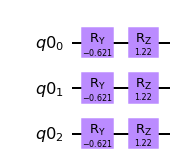

In [3]:
def U_in(x, nqubit):
    qr = QuantumRegister(nqubit)
    U = QuantumCircuit(qr)

    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)

    for i in range(nqubit):
        U.ry(angle_y, i)
        U.rz(angle_z, i)

    U.name = "U_in"
    return U

U_in(x_train[0], nqubit).draw('mpl')

### 変分フォームを使った状態変換<a id='func_variational_form'></a>

#### 変分量子回路$U(\boldsymbol{\theta})$の構成
次に、最適化すべき変分量子回路$U(\boldsymbol{\theta})$を作っていきます。これは以下の3つの手順で行います。

1. 2量子ビットゲートの作成（$\to$ 量子ビットをエンタングルさせる）
2. 回転ゲートの作成
3. 1.と2.のゲートを交互に組み合わせ、1つの大きな変分量子回路$U(\boldsymbol{\theta})$を作る

#### 2量子ビットゲートの作成
ここではControlled-$Z$ゲート（$CZ$）を使ってエンタングルさせ、モデルの表現能力を上げることを目指します。

#### 回転ゲートと$U(\boldsymbol{\theta})$の作成
$CZ$ゲートを使ってエンタングルメントを生成する回路$U_{\text{ent}}$と、$j \:(=1,2,\cdots n)$番目の量子ビットに適用する回転ゲート

$$
U_{\text{rot}}(\theta_j^l) = R_j^Y(\theta_{j3}^l)R_j^Z(\theta_{j2}^l)R_j^Y(\theta_{j1}^l)
$$

を掛けたものを組み合わせて、変分量子回路$U(\boldsymbol{\theta})$を構成します。ここで$l$は量子回路の層を表していて、$U_{\text{ent}}$と上記の回転ゲートを合計$d$層繰り返すことを意味しています。実際は、この演習では最初に回転ゲート$U_{\text{rot}}$を一度適用してから$d$層繰り返す構造を使うため、全体としては

$$
U\left(\{\theta_j^l\}\right) = \prod_{l=1}^d\left(\left(\prod_{j=1}^n U_{\text{rot}}(\theta_j^l)\right) \cdot U_{\text{ent}}\right)\cdot\prod_{j=1}^n U_{\text{rot}}(\theta_j^0)
$$

という形式の変分量子回路を用いることになります。つまり、変分量子回路は全体で$3n(d+1)$個のパラメータを含んでいます。$\boldsymbol{\theta}$の初期値ですが、$[0, 2\pi]$の範囲でランダムに設定するものとします。

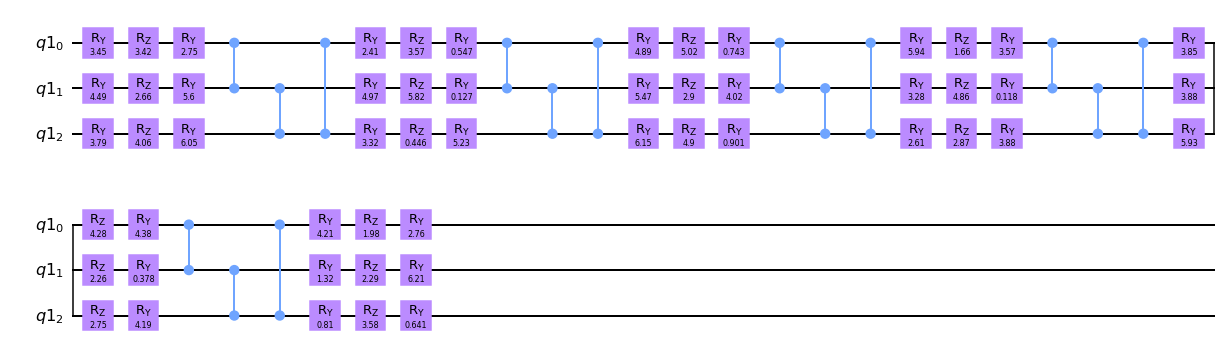

In [4]:
def U_out(nqubit, params):
    qr = QuantumRegister(nqubit)
    #cr = ClassicalRegister(nqubit)
    U = QuantumCircuit(qr)

    for i in range(nqubit):
        U.ry(params[i], i)
        U.rz(params[nqubit+i], i)
        U.ry(params[nqubit*2+i], i)
    for d in range(c_depth):
        for j in range(nqubit-1):
            U.cz(j, j+1)
        U.cz(nqubit-1, 0)
        for i in range(nqubit):
            U.ry(params[nqubit*(3*d+3)+i], i)
            U.rz(params[nqubit*(3*d+4)+i], i)
            U.ry(params[nqubit*(3*d+5)+i], i)
    U.name = "U_out"
    return U

U_out(nqubit, params).draw('mpl')

### 測定とモデル出力<a id='func_measurement'></a>

モデルの出力（予測値）として、状態$\ket{\psi_{\text{out}}(\mathbf{x},\boldsymbol{\theta})}=U(\boldsymbol{\theta})\ket{\psi_{\text{in}}(\mathbf{x})}$の元で最初の量子ビットを$Z$基底で測定した時の期待値を使うことにします。つまり$y(\mathbf{x},\boldsymbol{\theta}) = \langle Z_0(\mathbf{x},\boldsymbol{\theta}) \rangle = \langle \psi_{\text{out}}(\mathbf{x},\boldsymbol{\theta})|Z_0|\psi_{\text{out}}(\mathbf{x},\boldsymbol{\theta})\rangle$です。

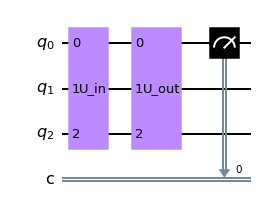

In [5]:
def pred_circ(x, nqubit, params):

    qr = QuantumRegister(nqubit, name='q')
    cr = ClassicalRegister(1, name='c')
    circ = QuantumCircuit(qr, cr)

    u_in = U_in(x, nqubit).to_instruction()
    u_out = U_out(nqubit, params).to_instruction()

    circ.append(u_in, qr)
    circ.append(u_out, qr)
    circ.measure(0, 0)

    return circ

pred_circ(x_train[0], nqubit, params).draw('mpl')

In [ ]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

def objective_function(params):
    cost_total = 0
    for i in range(len(x_train)):
        qc = pred_circ(x_train[i], nqubit, params)
        result = execute(qc, backend, shots=NUM_SHOTS).result()
        counts = result.get_counts(qc)
        exp_2Z = (2*counts['0']-2*counts['1'])/NUM_SHOTS
        cost = (y_train_noise[i] - exp_2Z)**2
        cost_total += cost

    return cost_total

ここで0と1の測定結果（固有値+1と-1）に2を掛けているのは、$Z$基底での測定結果の範囲を広げるためです。コスト関数$L$として、モデルの予測値と真の値$y_i$の平均2乗誤差の総和を使っています。

では、最後にこの回路を実行して、結果を見てみましょう。

In [ ]:
optimizer = COBYLA(maxiter=50, tol=0.05)
ret = optimizer.optimize(num_vars=num_vars, objective_function=objective_function, initial_point=params)

# 最適化したパラメータをプリントアウト
print('ret[0] =',ret[0])

x_list = np.arange(x_min, x_max, 0.02)
y_pred = []
for x in x_list:
    qc = pred_circ(x, nqubit, ret[0])
    result = execute(qc, backend, shots=NUM_SHOTS).result()
    counts = result.get_counts(qc)
    exp_2Z = (2*counts['0']-2*counts['1'])/NUM_SHOTS
    y_pred.append(exp_2Z)

# 結果を図示する
plt.plot(x_train, y_train_noise, "o", label='Training Data (w/ Noise)')
plt.plot(x_list, func_to_learn(x_list), label='Original Function')
plt.plot(x_list, np.array(y_pred), label='Predicted Function')
plt.legend()
plt.show()

生成された図を確認してください。ノイズを印加した学習データの分布から、元の関数$f(x)=x^3$をおおよそ導き出せていることが分かると思います。


## 素粒子現象の探索への応用<a id='susy'></a>

次の実習課題では、素粒子物理の基本理論（**標準模型**と呼ばれる）を超える新しい理論の枠組みとして知られている「**超対称性理論**」（*Supersymmetry*、略してSUSY）で存在が予言されている新粒子の探索を考えてみます。

### 学習データの準備<a id='susy_data'></a>

学習に用いるデータは、カリフォルニア大学アーバイン校（UC Irvine）の研究グループが提供する[機械学習レポジトリ](https://archive.ics.uci.edu/ml/index.php)の中の[SUSYデータセット](https://archive.ics.uci.edu/ml/datasets/SUSY)です。

In [ ]:
# ファイルから変数を読み出す
df = pd.read_csv("data/SUSY_1K.csv",
                 names=('isSignal','lep1_pt','lep1_eta','lep1_phi','lep2_pt','lep2_eta',
                        'lep2_phi','miss_ene','miss_phi','MET_rel','axial_MET','M_R','M_TR_2',
                        'R','MT2','S_R','M_Delta_R','dPhi_r_b','cos_theta_r1'))

# 学習に使う変数の数
feature_dim = 3  # dimension of each data point

# 3, 5, 7変数の場合に使う変数のセット
if feature_dim == 3:
    SelectedFeatures = ['lep1_pt', 'lep2_pt', 'miss_ene']
elif feature_dim == 5:
    SelectedFeatures = ['lep1_pt','lep2_pt','miss_ene','M_TR_2','M_Delta_R']
elif feature_dim == 7:
    SelectedFeatures = ['lep1_pt','lep1_eta','lep2_pt','lep2_eta','miss_ene','M_TR_2','M_Delta_R']

# 学習に使う事象数: trainingは訓練用サンプル、testingはテスト用サンプル
training_size = 20
testing_size = 20

# オプティマイザーをCallする回数の上限
niter = 100

random_seed = 10598

df_sig = df.loc[df.isSignal==1, SelectedFeatures]
df_bkg = df.loc[df.isSignal==0, SelectedFeatures]

# サンプルの生成
df_sig_training = df_sig.values[:training_size]
df_bkg_training = df_bkg.values[:training_size]
df_sig_test = df_sig.values[training_size:training_size+testing_size]
df_bkg_test = df_bkg.values[training_size:training_size+testing_size]
training_input = {'1':df_sig_training, '0':df_bkg_training}
test_input = {'1':df_sig_test, '0':df_bkg_test}
#print('train_input =',training_input)
#print('test_input =',test_input)

datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
datapoints_tr, class_to_label_tr = split_dataset_to_data_and_labels(training_input)

### 量子状態の生成<a id='susy_state_preparation'></a>

次は特徴量マップ$U_{\text{in}}(\mathbf{x}_i)$の作成ですが、ここでは

$$
U_{\phi_{\{k\}}}(\mathbf{x}_i)=\exp\left(i\phi_{\{k\}}(\mathbf{x}_i)Z_k\right)
$$

とします（$k$は入力値$\mathbf{x}_i$のベクトル要素の添字）。ここで$\phi_{\{k\}}(\mathbf{x}_i)=x_i^k$と決めて（$x_i^k$は$\mathbf{x}_i$の$k$番目要素）、入力値$\mathbf{x}_i$を$k$個の量子ビットに埋め込みます。この$U_{\phi_{\{k\}}}(x)$にアダマール演算子を組み合わせることで、全体として

$$
U_{\text{in}}(\mathbf{x}_i) = U_{\phi}(\mathbf{x}_i) H^{\otimes n},\:\:U_{\phi}(\mathbf{x}_i) = \exp\left(i \sum_{k=1}^n \phi_{\{k\}}(\mathbf{x}_i)Z_k\right)
$$

が得られます。

In [ ]:
feature_map = ZFeatureMap(feature_dim, reps=1)

### 変分フォームを使った状態変換<a id='susy_variational_form'></a>

変分量子回路$U(\boldsymbol{\theta})$は上の初歩的な例で用いた回路とほぼ同じですが、回転ゲートとして

$$
U_{\text{rot}}(\theta_j^l) = R_j^Z(\theta_{j2}^l)R_j^Y(\theta_{j1}^l)
$$

を使います。上の例では$U(\boldsymbol{\theta})$を自分で組み立てましたが、Qiskitにはこの$U(\boldsymbol{\theta})$を実装するAPIがすでに準備されているので、ここではそれを使います。

In [ ]:
two = TwoLocal(feature_dim, ['ry','rz'], 'cz', 'full', reps=1)
two.draw('mpl')

### 測定とモデル出力<a id='susy_measurement'></a>

測定やパラメータの最適化、コスト関数の定義も初歩的な例で用いたものとほぼ同じです。QiskitのAPIを用いるので、プログラムはかなり簡略化されています。

In [ ]:
# シミュレータで実行する場合
backend = Aer.get_backend('qasm_simulator')

# 量子コンピュータで実行する場合
#from qiskit import IBMQ
#IBMQ.enable_account('__your_token__')
#provider0 = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
#backend_name = 'ibmq_santiago'
#backend = provider0.get_backend(backend_name)


optimizer = COBYLA(maxiter=niter, disp=True)
vqc = VQC(optimizer, feature_map, two, training_input, test_input)

quantum_instance = QuantumInstance(backend=backend, shots=1024,
                                   seed_simulator=random_seed, seed_transpiler=random_seed,
                                   skip_qobj_validation=True)

result = vqc.run(quantum_instance)
print(" --- Testing success ratio: ", result['testing_accuracy'])

学習したモデルの出力に対して、閾値を設定することで信号とバックグラウンドの選別が可能になります。その選別性能を評価するために一般的に行われるのは、閾値を連続的に変化させた時に得られる選別効率を2次元平面上でプロットすることです。この曲線はROC（Receiver Operating Characteristic）曲線と呼ばれ、バックグラウンドの選別効率に対する信号の選別効率を相対的に評価するものです。

学習結果を使って、訓練用とテスト用のデータからROC曲線を描いてみます。

In [ ]:
# 結果を求める
predicted_probs, predicted_labels = vqc.predict(datapoints[0])
prob_test_signal = predicted_probs[:,1]
#predicted_classes = map_label_to_class_name(predicted_labels, vqc.label_to_class)
#print(" ---   Prediction:   {}".format(predicted_classes))
predicted_probs_tr, predicted_labels_tr = vqc.predict(datapoints_tr[0])
prob_train_signal = predicted_probs_tr[:,1]

# ROC曲線を描いてみる
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, thresholds = roc_curve(datapoints[1], prob_test_signal, drop_intermediate=False)
fpr_tr, tpr_tr, thresholds_tr = roc_curve(datapoints_tr[1], prob_train_signal, drop_intermediate=False)
roc_auc = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='Testing Data (AUC = %0.3f)' % roc_auc)
plt.plot(fpr_tr, tpr_tr, color='darkblue', lw=2, label='Training Data (AUC = %0.3f)' % roc_auc_tr)
plt.plot([0, 0], [1, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

コードがうまく動けば、訓練用とテスト用データから求めたROC曲線が描かれているはずです。

この結果を見てどう思うでしょうか？機械学習を知っている方であれば、この結果はお世辞にも良いようには見えませんね。。訓練用のデータでは学習ができている、つまりバックグラウンドの選別効率（False Positive Rate）より信号の選別効率（True Positive Rate）の方が高くなっていますが、テスト用のサンプルではROC曲線が対角線にほぼへばりついていて、全く学習効果が見えていません。これは「過学習」を起こしている場合に見られる典型的な症状で、訓練データのサイズに対して学習パラメータの数が多すぎるときによく起こります。